# CalCS Subboxes Decomposition

M. Jacox suggests that I look into the decomposition for the California Current subboxes -- i.e. the onshore and offshore boxes that I used to correlate to the PDO/NPGO.

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import seaborn as sns
import pandas as pd

In [2]:
def get_indices(str):
    """
    Given a string ("offshore" or "onshore") returns the x0, x1, y0,
    y1 indices for slicing to the desired box.
    """
    if str.lower() == 'offshore':
        x0,x1,y0,y1 = [13,15,27,30]
    elif str.lower() == 'onshore':
        x0,x1,y0,y1 = [18,20,22,25]
    return x0,x1,y0,y1

In [3]:
def drop_ensemble_dim(ds, x):
    ds[x] = (('nlat', 'nlon'), ds[x][0])
    return ds

## Extract Box Time Series for Each Variable (not circ)

Only needs to be run the first time

In [4]:
VAR = 'sDIC_int100m_tendency'
REG = 'offshore'

In [5]:
filepath = ('/glade/work/rbrady/EBUS_BGC_Variability/' + VAR + '/CalCS/')
ds = xr.open_mfdataset(filepath + '*.nc', concat_dim='ensemble')
try:
    ds = drop_ensemble_dim(ds, 'TLAT')
    ds = drop_ensemble_dim(ds, 'TLONG')
    ds = drop_ensemble_dim(ds, 'TAREA')
except:
    pass
x0,x1,y0,y1 = get_indices(REG)
ds = ds.isel(nlon=slice(x0, x1+1), nlat=slice(y0, y1+1))
area = ds['TAREA']
da = ds[VAR]
da = ((da * area).sum('nlat').sum('nlon')) / area.sum()
# Convert to proper units
conversions = {'sDIC_int100m_tendency': (12/10**3),
               'Jint_100m_DIC': (60*60*24*365) / (10**5),
               'FG_CO2': 1}
da = da * conversions[VAR]
da.name = VAR
ds = da.to_dataset()
ds_forced = ds.mean('ensemble')
ds_forced.attrs['units'] = 'mol/m2/yr'
ds_residuals = ds[VAR] - ds_forced
ds_residuals.attrs['units'] = 'mol/m2/yr'

In [6]:
directory = ('/glade/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' +
             REG.lower() + '/' + VAR + '/')
if not os.path.exists(directory):
    os.makedirs(directory)
print("Saving forced signal to NetCDF...")
ds_forced.to_netcdf(directory + 'CalCS.' + VAR + '.' + REG.lower() + 
                    '.forced-signal.nc')
print("Saving residuals to NetCDF...")
ds_residuals.to_netcdf(directory + 'CalCS.' + VAR + '.' + REG.lower() + 
                       '.residuals.nc')

Saving forced signal to NetCDF...


/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


Saving residuals to NetCDF...


/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


## Determine Circulation Residual

This is run after creating offshore/onshore for the other three variables.

In [7]:
REG = 'offshore'

In [8]:
def create_total(VAR):
    """
    The CalCS boxes were saved out as a forced signal and the residuals. Just
    adding them back together to create the total trajectory for each
    simulation. I'll use these to reconstruct the circulation residual.
    """
    directory = ('/glade/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' +
                 REG + '/' + VAR + '/')
    forced = xr.open_dataset(directory + 'CalCS.' + VAR + '.' + REG +
                             '.forced-signal.nc')
    resid  = xr.open_dataset(directory + 'CalCS.' + VAR + '.' + REG +
                             '.residuals.nc')
    return forced + resid

In [9]:
def load_variables():
    """
    Loads in FG_CO2, Jint_100m_DIC, and sDIC_int100m_tendency for the given
    box (onshore/offshore) which will be used to compute the circulation
    residual.
    """
    co2_flux = create_total('FG_CO2')
    int_dic = create_total('Jint_100m_DIC')
    tendency = create_total('sDIC_int100m_tendency')
    return co2_flux, int_dic, tendency

In [10]:
co2_flux, int_dic, tendency = load_variables()
# Compute circulation residual.
co2_flux = co2_flux.isel(ensemble=slice(1, 34))
int_dic = int_dic.isel(ensemble=slice(1, 34))
circ = tendency['sDIC_int100m_tendency'] - co2_flux['FG_CO2'] - \
       int_dic['Jint_100m_DIC']
# Attributes, aesthetics
circ.name = 'Jint_100m_circ'
circ.attrs['units'] = 'mol/m2/yr'
circ.attrs['description'] = 'Residual computed by subtracting J_ex and ' + \
                            'J_bio from the reconstructed tendency term.'  
# Compute ensemble mean and residuals
circ_forced = circ.mean('ensemble')
circ_residuals = circ - circ_forced

In [11]:
directory = ('/glade/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' +
             REG.lower() + '/Jint_100m_circ/')
if not os.path.exists(directory):
    os.makedirs(directory)
print("Saving forced signal to NetCDF...")
circ_forced.to_netcdf(directory + 'CalCS.Jint_100m_circ.' + REG.lower() + 
                    '.forced-signal.nc')
print("Saving residuals to NetCDF...")
circ_residuals.to_netcdf(directory + 'CalCS.Jint_100m_circ.' + REG.lower() + 
                       '.residuals.nc')

Saving forced signal to NetCDF...
Saving residuals to NetCDF...


/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


## sDIC Decomposition

In [12]:
def load_variables(REG):
    v_list = ['FG_CO2', 'Jint_100m_circ', 'Jint_100m_DIC', 
              'sDIC_int100m_tendency']
    basepath = '/glade/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' + REG + \
               '/'
    ds = xr.Dataset()
    for name in v_list:
        filepath = (basepath + name + '/CalCS.' + name + '.' + REG +
                    '.residuals.nc')
        temp_ds = xr.open_dataarray(filepath)
        if name == 'FG_CO2' or name == 'Jint_100m_DIC':
            temp_ds = temp_ds.isel(ensemble=slice(1,34))
        ds = xr.merge([ds, temp_ds])
    return ds

In [14]:
def load_index(idx):
    if idx == 'NPGO':
        ds = xr.open_mfdataset('/glade/p/work/rbrady/EBUS_BGC_Variability/NPGO/*.nc', 
                              concat_dim='ensemble')
        ds = ds.isel(ensemble=slice(1,34))
        ds = ds['pc'].to_dataset()
        ds = ds.rename({'pc': 'NPGO'})
    else:
        ds = xr.open_dataset('/glade/work/rbrady/cesmLE_CVDP/processed/' + 
                             'cvdp_detrended_BGC.nc')
        ds = ds[idx]
        ds = ds.isel(ensemble=slice(1,34))
    return ds

In [15]:
def regression(ds):
    m1, m2, m3, m4 = ([] for i in range(4))
    for label, group in ds.groupby('ensemble'):
        """
        The manually integrate
        """
        M1, _, _, _, _ = et.stats.linear_regression(group['index'], 
                                                    group['FG_CO2'])
        M2, _, _, _, _ = et.stats.linear_regression(group['index'], 
                                                    group['Jint_100m_circ'])
        M3, _, _, _, _ = et.stats.linear_regression(group['index'], 
                                                    group['Jint_100m_DIC'])
        M4, _, _, _, _ = et.stats.linear_regression(group['index'], 
                                                group['sDIC_int100m_tendency'])
    #    R, P, N = et.stats.pearsonr(group['NPGO'], group['FG_CO2_AW'])
        m1.append(M1)
        m2.append(M2)
        m3.append(M3)
        m4.append(M4)
    results = xr.Dataset({'CO2': ('ensemble', m1),
                      'Circulation': ('ensemble', m2),
                      'Biology': ('ensemble', m3),
                      'Tendency': ('ensemble', m4)}) 
    return results

This is just for raw values for the table...

In [16]:
REG = 'offshore'
IDX = 'pdo'
ds = load_variables(REG)

# Load in index
index = load_index(IDX)
ds = xr.merge([ds, index])
ds = ds.rename({IDX: 'index'})

In [17]:
results = regression(ds)

# Visualization

In [18]:
def create_pandas(da, df, location):
    """
    da : dataarray to add to dataframe
    df : dataframe you are appending this to
    """
    temp_df = da.to_dataframe()
    temp_df.columns = ['value']
    temp_df['variable'] = da.name
    temp_df['location'] = location
    df = pd.concat([df, temp_df])
    return df

def relative_values(ds):
    """
    Computes values of three contributors relative
    to their sum. This allows comparison between systems.
    """
    # Percent of absolute total
    co2 = np.abs(ds['CO2']) / (np.abs(ds['CO2']) + \
                 np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    bio = np.abs(ds['Biology']) / (np.abs(ds['CO2']) + \
                 np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    circ = np.abs(ds['Circulation']) / (np.abs(ds['CO2']) + \
                  np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    # Give original sign
    ds = ds.where(ds > 0, -1)
    ds = ds.where(ds < 0, 1)
    co2 = co2 * ds['CO2'] * 100
    co2.name = 'co2'
    bio = bio * ds['Biology'] * 100
    bio.name = 'bio'
    circ = circ * ds['Circulation'] * 100
    circ.name = 'circ'
    return co2, bio, circ

## Relative Values

In [19]:
pairs = {'offshore': 'pdo', 
         'onshore': 'pdo'}
df = pd.DataFrame()
for L, I in pairs.items():
    ds = load_variables(L)
    index = load_index(I)
    ds = xr.merge([ds, index])
    ds = ds.rename({I: 'index'})
    ds = regression(ds)
#    conversion = 12 * total_area / 10**9
#    ds = ds * conversion
    # Convert to relative values
    co2, bio, circ = relative_values(ds)
    
    # Set up in Pandas
    df = create_pandas(co2, df, L)
    df = create_pandas(bio, df, L)
    df = create_pandas(circ, df, L)

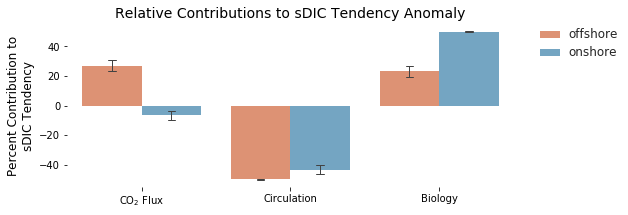

In [20]:
f, ax = plt.subplots(figsize=(8,3))

plt.style.use('seaborn-whitegrid')
clist = ['#ef8a62', '#67a9cf']

sns.barplot(x='variable', y='value', hue='location', data=df,
           ci='sd', capsize=0.05, errwidth=1, 
           order=list(['co2', 'circ', 'bio']), palette=clist)

ax.set_xticklabels(['CO$_{2}$ Flux','Circulation','Biology'])
ax.set_xlabel('')
ax.set_ylabel('Percent Contribution to' + '\n' + 'sDIC Tendency', fontsize=12)
ax.set_title('Relative Contributions to sDIC Tendency Anomaly', fontsize=14)

sns.despine(left=True, bottom=True)
et.vis.outer_legend()
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)


et.vis.savefig('relative_sDIC_decomposition_CalCS_boxes', extension='.eps', 
               dpi=300)